In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

from utilities import *

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


PyTorch Version: 1.8.1
Torchvision Version: 0.2.2
GPU is available? True


In [2]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imported datasets
For the testing and comparison of our algorithms we will use the following datasets:

1. MNIST

In [3]:
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

# Train - test split

Code taken from https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb

In [4]:
#train-set initialization
x_d0 = mnist_trainset[0][0].size()[0]
x_d1 = mnist_trainset[0][0].size()[1]
x_d2 = mnist_trainset[0][0].size()[2]
N = x_d3 = len(mnist_trainset)
K = 10
x_train = torch.empty((N,x_d0*x_d1*x_d2), device=device)
y_train = torch.empty(N, dtype=torch.long)
for i in range(N): 
    x_train[i,:] = torch.reshape(mnist_trainset[i][0], (1, x_d0*x_d1*x_d2))
    y_train[i] = mnist_trainset[i][1]
x_train = torch.t(x_train)
#y_one_hot = torch.zeros(N, K).scatter_(1, torch.reshape(y_train, (N, 1)), 1)
#y_one_hot = torch.t(y_one_hot).to(device=device)
y_train = y_train.to(device=device)

#test-set initialization
N_test = x_d3_test = len(mnist_testset)
x_test = torch.empty((N_test,x_d0*x_d1*x_d2), device=device)
y_test = torch.empty(N_test, dtype=torch.long)
for i in range(N_test): 
    x_test[i,:] = torch.reshape(mnist_testset[i][0], (1, x_d0*x_d1*x_d2))
    y_test[i] = mnist_testset[i][1]
x_test = torch.t(x_test)
#y_test_one_hot = torch.zeros(N_test, K).scatter_(1, torch.reshape(y_test, (N_test, 1)), 1)
#y_test_one_hot = torch.t(y_test_one_hot).to(device=device)
y_test = y_test.to(device=device)

In [5]:
batch_size = 1000

dataset_test = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True, transform=torchvision.transforms.ToTensor()), 
  batch_size=100,
  shuffle=True
)
dataset_train = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
  batch_size=batch_size,
  shuffle=True
)

# Base architecture

For the MultiLayerPerceptron we have the parameters **input_size** , **hidden_size**,**output_size** corresponding to the size of the input layer, the hidden layer and the output layer, respectively.

The MLP only has 3 layers like https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb as a starting point.

Also we use ReLU currently for the same reason.

In [6]:
input_size = 28*28
hidden_size = 1500
output_size = 10

In [7]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.fc_in = nn.Linear(self.input_size,self.hidden_size,bias=True) #fully connected input_layer
        self.fc_hid_1 = nn.Linear(self.hidden_size,self.hidden_size,bias=True) #fully connected hidden_layer_1
        self.fc_hid_2 = nn.Linear(self.hidden_size,self.hidden_size,bias=True) #dully connected hidden_layer_2
        self.fc_out = nn.Linear(self.hidden_size,self.output_size,bias=True)
    
    def forward(self,x):
        batch_size = x.shape[0]
        x = x.view(batch_size, self.input_size)
        x = self.relu(self.fc_in(x))
        x = self.relu(self.fc_hid_1(x))
        x = self.relu(self.fc_hid_2(x))
        x = self.fc_out(x)
        return x    

In [8]:
#initialize the model
mlp = MultiLayerPerceptron().to(device)

# Optimizers & Loss functions Definitions

1. SGD from pytorch 
2. CrossEntropyLoss function criterion

In [9]:
learning_rate = 0.001

optimizer_SGD = optim.SGD(mlp.parameters(), lr=learning_rate, momentum=0.9)

cross_entropy = nn.CrossEntropyLoss()

#optimizer_Adam = optim.Adam(mlp.parameters(), lr=learning_rate)

# Training

Note: Fix it so that it moves everything to device in the following function and that it does the label sample split here

In [11]:
def train_model(model,dataset_train,dataset_test,optimizer,criterion,epochs):
    train_losses = []
    accuracies = []
    
    for epoch in range(epochs): # loop over the dataset multiple times
        epoch_loss = 0.0 
        model.train()
        running_loss = 0
        n_steps =0
        for batch_x,batch_y in dataset_train:
            n_steps = n_steps+1
            batch_x,batch_y = batch_x.to(device),batch_y.to(device)

            #Get output and evaluate with loss function
            predictions = model(batch_x)
            loss = criterion(predictions,batch_y)
            running_loss += loss.item() * len(batch_y)
    
            #Initialize optimizer
            optimizer.zero_grad()
            loss.backward()

            #Update the network
            optimizer.step()
        
        running_loss = running_loss / n_steps
        train_losses.append(running_loss)
        
        #Test the quality on the test set
        model.eval()
        accuracies_test = []
        
        for batch_x, batch_y in dataset_test:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            accuracies_test.append(accuracy(prediction, batch_y))
    
        print("Epoch {} | Test accuracy: {:.5f}".format(epoch, sum(accuracies_test).item()/len(accuracies_test)))
        
        accuracies.append(sum(accuracies_test).item()/len(accuracies_test))
    return train_losses, accuracies

In [12]:
num_epochs = 50

start = time.time()

#train using sgd
train_losses_SGD, accuracies_test_SGD = train_model(mlp, dataset_train, dataset_test, optimizer_SGD, cross_entropy, num_epochs)

end = time.time()
print('\n')
print('The total time spent is', end - start)

Epoch 0 | Test accuracy: 0.24060
Epoch 1 | Test accuracy: 0.31140
Epoch 2 | Test accuracy: 0.37380
Epoch 3 | Test accuracy: 0.44610
Epoch 4 | Test accuracy: 0.49150
Epoch 5 | Test accuracy: 0.52670
Epoch 6 | Test accuracy: 0.56790
Epoch 7 | Test accuracy: 0.60660
Epoch 8 | Test accuracy: 0.64920
Epoch 9 | Test accuracy: 0.68720
Epoch 10 | Test accuracy: 0.70870
Epoch 11 | Test accuracy: 0.72160
Epoch 12 | Test accuracy: 0.75080
Epoch 13 | Test accuracy: 0.77330
Epoch 14 | Test accuracy: 0.78790
Epoch 15 | Test accuracy: 0.80080
Epoch 16 | Test accuracy: 0.81130
Epoch 17 | Test accuracy: 0.82390
Epoch 18 | Test accuracy: 0.83450
Epoch 19 | Test accuracy: 0.84090
Epoch 20 | Test accuracy: 0.84850
Epoch 21 | Test accuracy: 0.85670
Epoch 22 | Test accuracy: 0.86290
Epoch 23 | Test accuracy: 0.86730
Epoch 24 | Test accuracy: 0.86990
Epoch 25 | Test accuracy: 0.87400
Epoch 26 | Test accuracy: 0.87770
Epoch 27 | Test accuracy: 0.88070
Epoch 28 | Test accuracy: 0.88350
Epoch 29 | Test accuracy

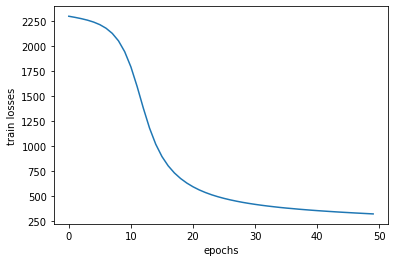

In [13]:
## We plot the train losses

plot_train_losses(num_epochs, train_losses_SGD, 'SGD')

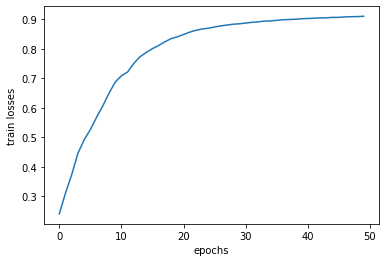

In [14]:
## We plot the test accuracy

plot_test_accuracy(num_epochs, accuracies_test_SGD, 'SGD')